In [1]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
from preprocessing import (
    load_all_bands,
    calculate_rgb,
    calculate_ndvi
)
from segmentation import manual_treshold_segmentation

In [43]:
path = "/Users/devseed/Documents/repos/OBIA_workflow/data/000000000699.tif"

In [49]:
band_list = load_all_bands(path)

Number of bands: 12


In [53]:
red = band_list[1]
green = band_list[2]
blue = band_list[3]
nir = band_list[4]

In [54]:
ndvi = calculate_ndvi(red, nir)

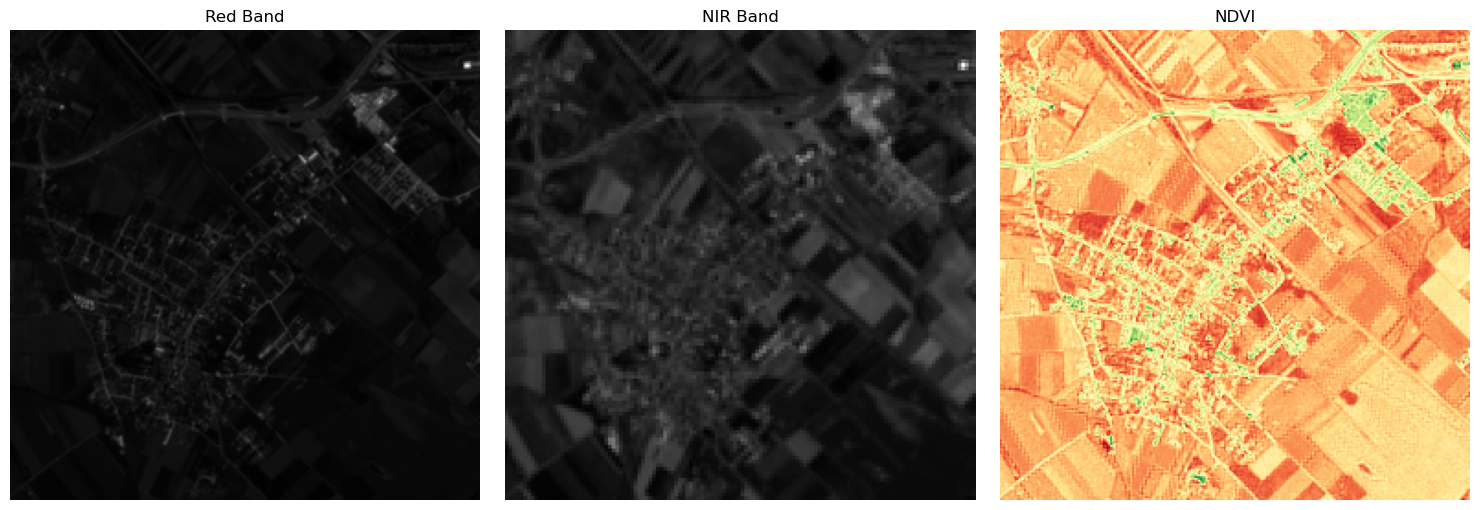

In [55]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].imshow(red, cmap="gray")
axs[0].set_title("Red Band")
axs[0].axis("off")

axs[1].imshow(nir, cmap="gray")
axs[1].set_title("NIR Band")
axs[1].axis("off")

axs[2].imshow(ndvi, cmap="RdYlGn")
axs[2].set_title("NDVI")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [60]:
rgb = calculate_rgb(red, green, blue)

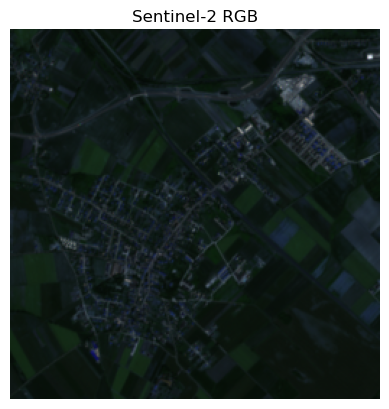

In [61]:
plt.imshow(rgb)
plt.title("Sentinel-2 RGB")
plt.axis("off")
plt.show()

In [62]:
manual_treshold = manual_treshold_segmentation(ndvi, 0, 0.1, 0.2, 0.5)

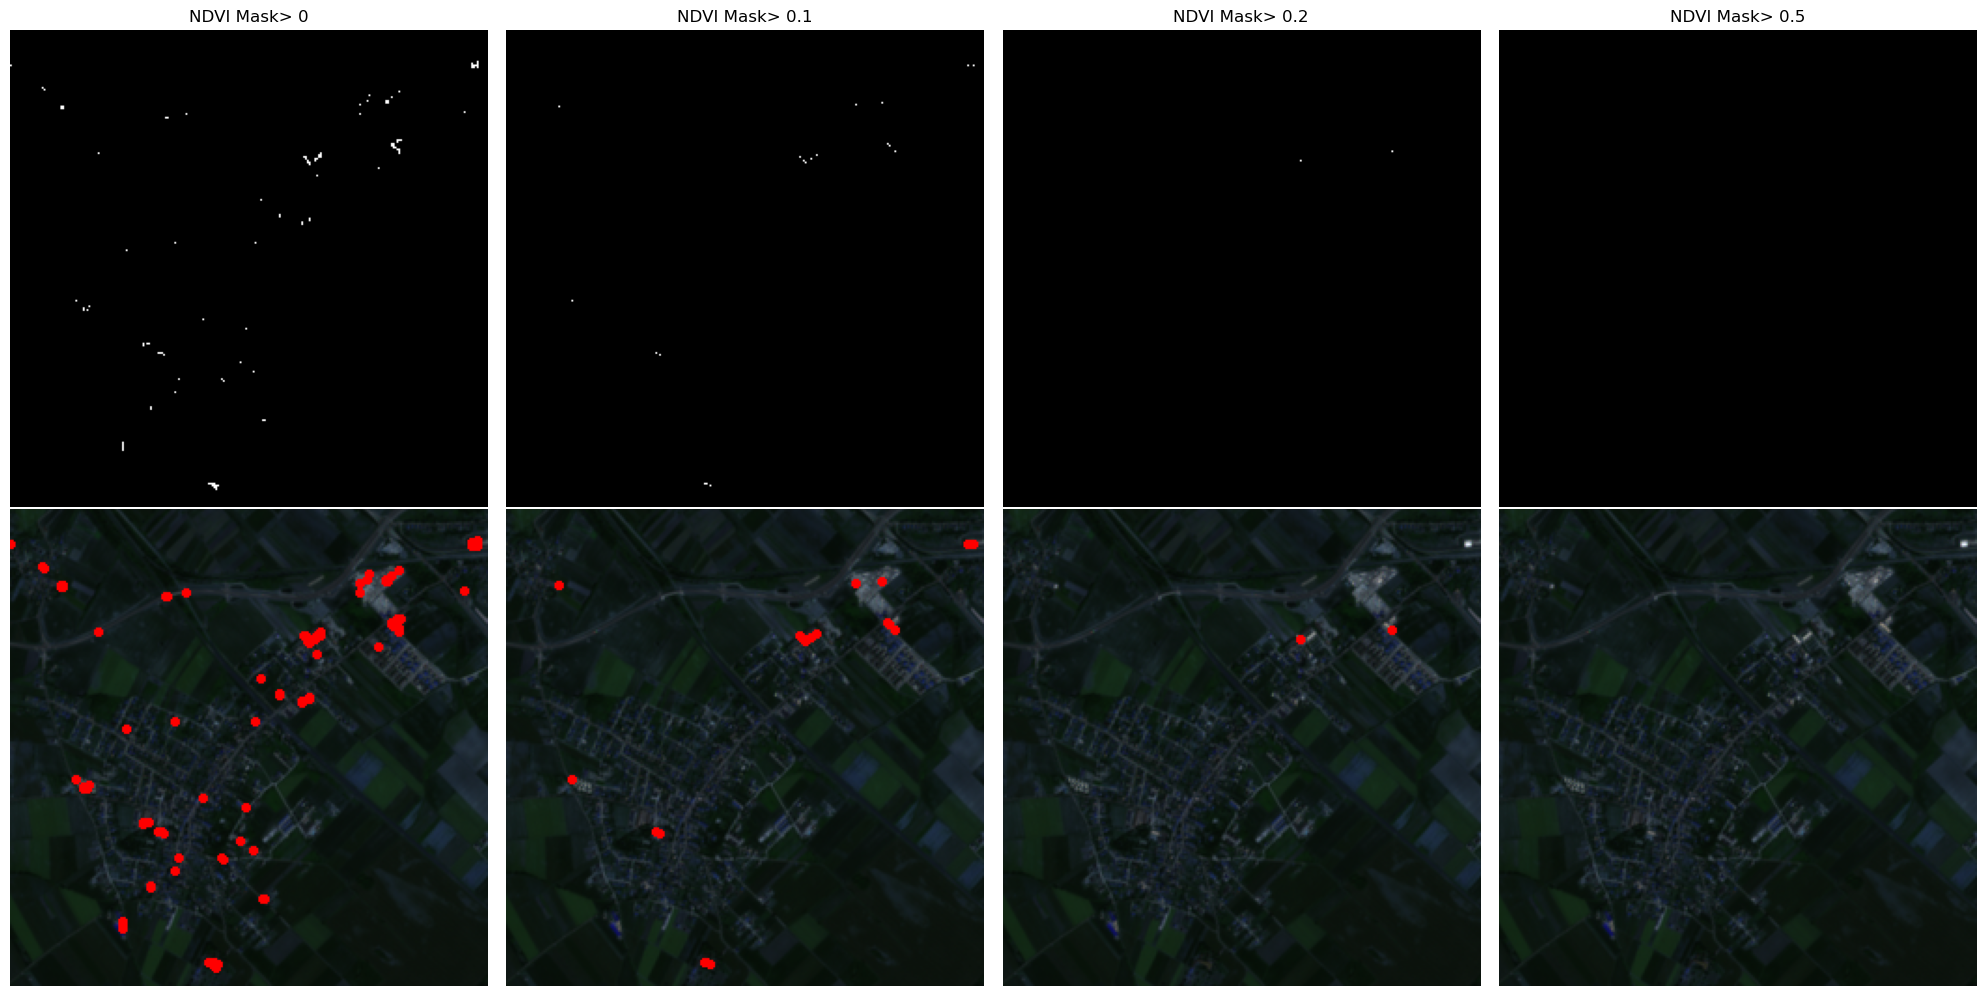

In [63]:
# Define NDVI thresholds
thresholds = [0, 0.1, 0.2, 0.5]

# Create the figure for the subplots
fig, axs = plt.subplots(
    ncols=len(thresholds),
    nrows=2,
    figsize=(5 * len(thresholds), 10)
)

# Loop through each threshold to create masks and plot them
for i, threshold in enumerate(thresholds):
    # Create a binary mask where NDVI is greater than the threshold
    mask = ndvi > threshold

    # Plot the mask (binary image where NDVI > threshold)
    axs[0, i].imshow(mask, cmap="gray")
    axs[0, i].set_title(f"NDVI Mask> {threshold}")
    axs[0, i].axis("off")

    # Plot the RGB image with boundaries marked around the NDVI mask
    axs[1, i].imshow(mark_boundaries(rgb, mask, color=(1,0,0), outline_color=(1,0,0), mode="thick")) # Define boundary plotting settings
    axs[1, i].axis("off")

# Display the plots
plt.tight_layout()
plt.show()

Loading Sentinel-2 image...
Image loaded: (877, 1164)
Calculating spectral indices...
Performing edge-based segmentation...


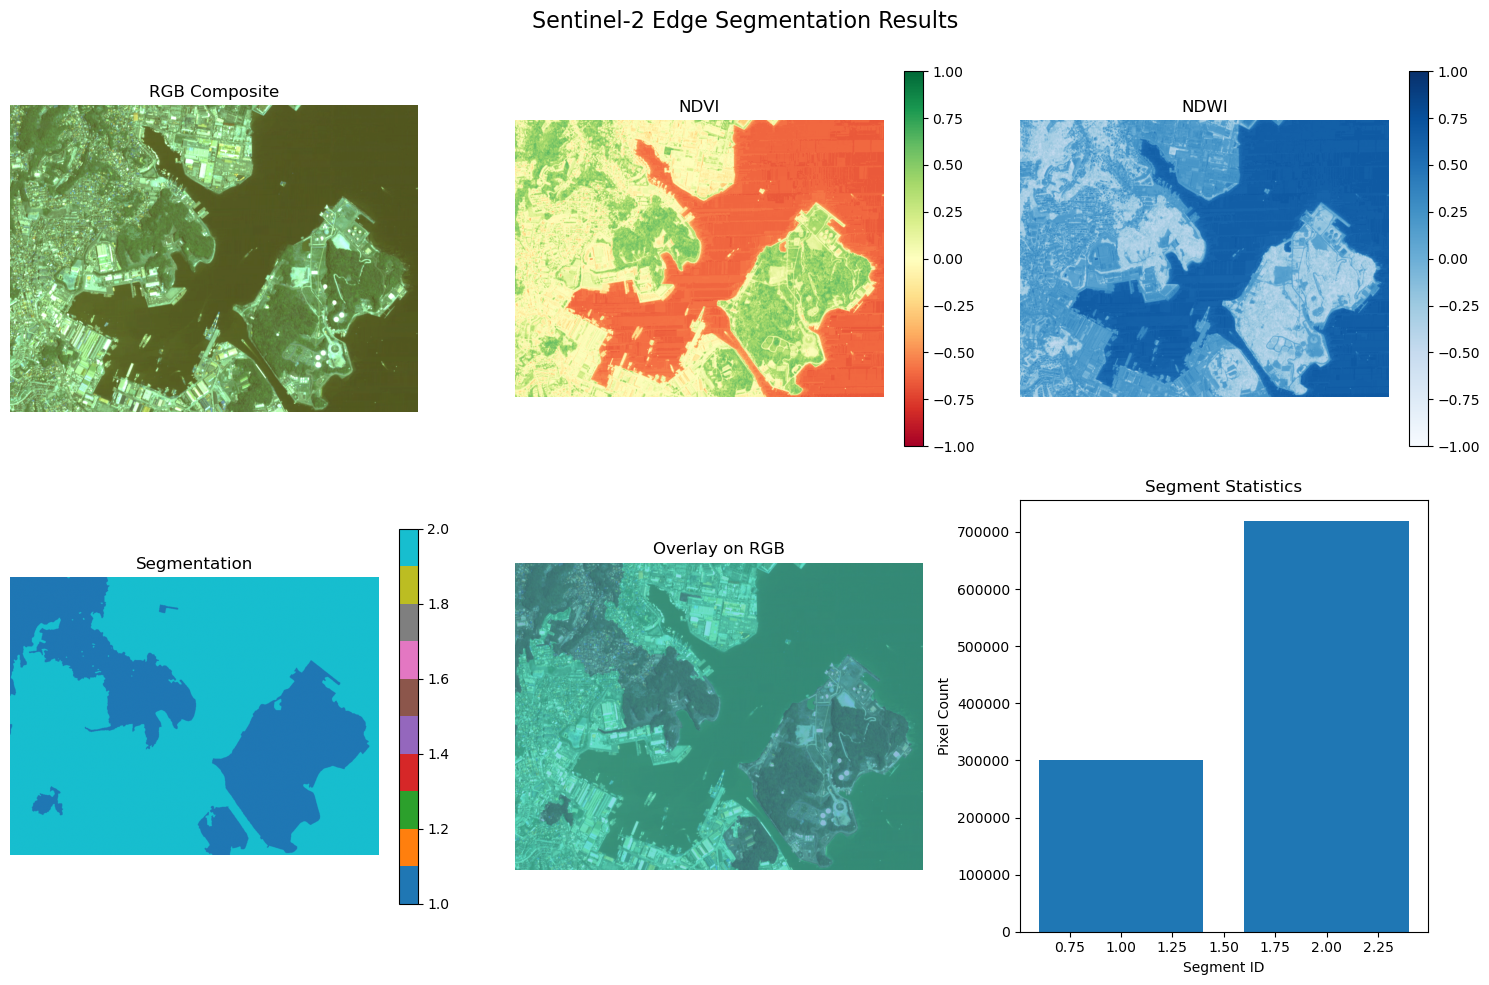


Segmentation Statistics:
segment_1: 301549 pixels, NDVI: 0.316, NDWI: -0.169
segment_2: 719279 pixels, NDVI: -0.326, NDWI: 0.409
